# ULM-FiT for sentiment analysis


## import dependency

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from fastai.text.all import *

## import dataset
we going to use sentiment data from US airline for sentiment analysis

https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [ ]:
# import dataset
df = pd.read_csv(r'https://raw.githubusercontent.com/satyajeetkrjha/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv')[['text','airline_sentiment']]
df.columns = ['text','label']
len(df)

14640

In [ ]:
df = df[df['label'].notna()]
len(df)

14640

In [ ]:
# create fastai dataset
data_lm = TextDataLoaders.from_df(df)

In [ ]:
# show top 5 samples
data_lm.show_batch(max_n=5)

,text,category
0,xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - jac 29 / 9 xxup jac - lax 8 / 10 xxup lax - dub 13 / 10 . xxmaj i 'm * g. xxmaj what is checked bag allowance for xxup jac - lax ?,neutral
1,xxbos @usairways xxup xxunk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup xxunk xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup xxunk u xxup and,negative
2,xxbos @virginamerica xxmaj many xxmaj thanks for the xxmaj follow . \n▁ # xxunk # xxunk # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 🇬 🇧 💗 🇺 🇸 💗 \n 🎀 xxunk 🎀 http : / / t.co / xxunk,neutral
3,"xxbos @usairways 4 segments , 4 / 4 delayed . xxmaj gnv > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup gnv . xxmaj my year off from flying with you guys was the way to go .",negative
4,xxbos @americanair xxmaj hi . i have xxup koa - lax - phl - ord booked as a 1 - way xxunk xxunk . xxmaj if i called to xxunk it to xxup koa - lax - phx - ord would i have to pay any fees,neutral


## fine-tuning pre-trained model

In [ ]:
# feed dataloader from fastai 
# select the pre-trained model, --> AWD_LSTM is a based model for UMLFiT
# set dropout at 0.5
# use accuracy as a monitoring metric
# apply mix precision to reduce training time --> to_fp16()
## set model configuation
learn = text_classifier_learner(data_lm, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

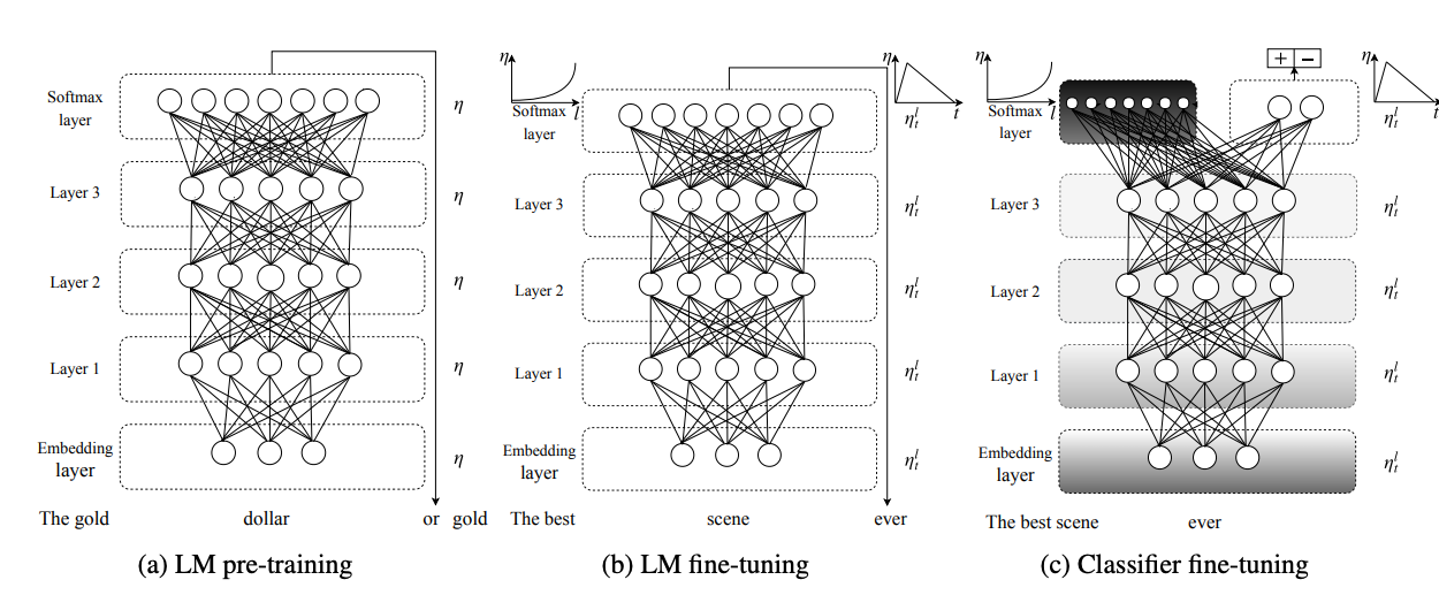

we will perform C, fine-tuning model by task specific, which is the sentiment analysis

In [ ]:
# fine-tuning pre-trained model for 4 epochs with learning rate of 1e-2
  # learning rate must be lower as 1e-5 to 1e-6, with larger number of epochs
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.816099,0.676112,0.724727,00:18


epoch,train_loss,valid_loss,accuracy,time
0,0.661463,0.561227,0.766052,00:19
1,0.590536,0.496913,0.797814,00:19
2,0.503170,0.487878,0.809426,00:20
3,0.377850,0.488516,0.815915,00:20


In [ ]:
# print a precdiction results
learn.show_results()

,text,category,category_
0,"xxbos @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive,negative
1,"xxbos @united xxmaj hi , xxmaj i m flying xxup sfo - lax - xxunk - xxunk . xxmaj my connecting time in xxup lax is xxunk m. xxmaj is it enough time ? xxmaj do i have to collect my bag and xxunk on xxup xxunk ?",neutral,neutral
2,"xxbos .@americanair ( 2 / 3 ) … i sat on the runway for 4 xxup more xxup hrs b4 takeoff ( 10 hrs xxmaj late xxmaj flight , xxunk xxup am ) . xxmaj pilot xxunk stated it was a comp / mech issue .",negative,negative
3,xxbos @united xxmaj this is xxup not a local xxup united number for xxmaj xxunk xxunk xxunk xxrep 4 5 8 xxrep 3 0 . xxmaj what is your local xxmaj united xxmaj airlines here in xxmaj xxunk xxmaj xxunk ( xxup xxunk ) ?,neutral,negative
4,xxbos @usairways xxup you xxup are xxup amazing xxrep 3 ! xxup you xxup are xxup the xxup best xxrep 3 ! xxup follow xxup me xxup please xxup and i xxup follow xxup you xxup back ;) xxrep 3 🙏 ✌ ️ 😉 ),positive,positive
5,"xxbos @usairways i need help . xxmaj in air on # xxunk to xxup clt from xxup phl . xxmaj conf : xxup xxunk xxmaj need confirmed on # xxunk to xxup bna at 10:30 . xxmaj been bumped all day , need home",negative,negative
6,xxbos @southwestair no delay . i pay $ xxrep 3 7 xxunk for xxup bs xxup a1 ticket . xxmaj you boarded flight early . xxmaj i 'm last to board . xxmaj now have middle seat . xxmaj wasted xxrep 4 $ !,negative,negative
7,"xxbos @united xxmaj waiting for xxunk xxup ewr - ord , delayed 47 mins . xxmaj might miss xxunk xxup ord - xxunk at 6 pm xxup ct . xxmaj any room on xxunk xxup ord - xxunk in case i miss xxunk ?",negative,negative
8,"xxbos @americanair xxmaj as i already have a booked flight that i ca n't use & & ca n't change w / o a $ 200 fee , xxmaj flight xxmaj booking xxmaj problems a different type of ticket … 1 / 2",negative,negative


In [ ]:
# test a model with new sentence
learn.predict("I really liked that movie!")

('negative', tensor(0), tensor([0.4532, 0.1383, 0.4085]))

In [ ]:
learn.predict("I do not like that movie!")

('negative', tensor(0), tensor([0.8756, 0.1128, 0.0117]))

## save and load fine-tuned model

In [ ]:
# save learner
# save into /models/awd_lstm_fully_trained_export
learn.export('awd_lstm_fully_trained_export')

In [ ]:
def get_learner_for_inference(export_model_path: str):
    learn = load_learner(export_model_path).to_fp16()
    # ensure learner is loaded on gpu cuda
    learn.dls.cuda()
    print(f'Learner stored on {learn.dls.device.type}')
    return learn

In [ ]:
learn = get_learner_for_inference('/content/awd_lstm_fully_trained_export')

Learner stored on cuda


## model evaluation

we only evaluate the model for task specific not for LM

In [ ]:
# to save time only select first 200 samples for evaluation purpose
y_true = df['label'].head(200)

In [ ]:
# run a prediction model by learn.predict
y_pred = df['text'].head(200).apply(lambda x: learn.predict(x)[0])

In [ ]:
# calculate evaluation metric
  # we use accuracy as the evaluation metric
acc = (y_true == y_pred).sum() / len(y_true)
print('accuracy =', acc)

accuracy = 0.84
